<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers import Bidirectional

In [2]:
from google.colab import files
import io

### Datos
Utilizaremos como dataset letras de cancions de queen.

In [3]:
uploaded =files.upload()

Saving queen_lyrics.csv to queen_lyrics.csv


In [4]:
queen = pd.read_csv(io.BytesIO(uploaded['queen_lyrics.csv']), sep=",")

In [5]:
queen.head()

,album,track_title,track_n,lyric,line
0,Queen,Keep Yourself Alive,1,I was told a million times of all the troubles...,1
1,Queen,Keep Yourself Alive,1,Mind you grow a little wiser little better eve...,2
2,Queen,Keep Yourself Alive,1,But if I crossed a million rivers and I rode a...,3
3,Queen,Keep Yourself Alive,1,Then I'd still be where I started bread and bu...,4
4,Queen,Keep Yourself Alive,1,Well I sold a million mirrors In a shopping al...,5


In [6]:
queen = queen.drop(columns=["album", "track_title", "track_n", "line"])

In [7]:
uploaded =files.upload()

Saving beatles.txt to beatles.txt


In [9]:
beatles = pd.read_table(io.BytesIO(uploaded['beatles.txt']), header=None, delimiter=None)

In [10]:
beatles.columns= ["lyric"]

In [10]:
beatles.head()

,lyric
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


In [11]:
uploaded =files.upload()
adele = pd.read_table(io.BytesIO(uploaded['adele.txt']), header = None, delimiter=None)
adele.columns = ["lyric"]

Saving adele.txt to adele.txt


In [12]:
uploaded =files.upload()
blink = pd.read_table(io.BytesIO(uploaded['blink.txt']), header=None, delimiter=None)
blink.columns = ["lyric"]

Saving blink.txt to blink.txt


In [13]:
df = ((queen.append(beatles, ignore_index = True)).append(adele, ignore_index =True)).append(blink, ignore_index = True)

<ipython-input-13-d086f934b618>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = ((queen.append(beatles, ignore_index = True)).append(adele, ignore_index =True)).append(blink, ignore_index = True)


In [14]:
df

,lyric
0,I was told a million times of all the troubles...
1,Mind you grow a little wiser little better eve...
2,But if I crossed a million rivers and I rode a...
3,Then I'd still be where I started bread and bu...
4,Well I sold a million mirrors In a shopping al...
...,...
7182,The only time I feel alive is when I find some...
7183,(The last train home)
7184,(I'll take the last train home)
7185,The only time I feel alive is when I find some...


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [14]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 3

In [16]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df['lyric'][0]
text

'I was told a million times of all the troubles in my way'

In [ ]:
type(text)

str

In [17]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['i',
 'was',
 'told',
 'a',
 'million',
 'times',
 'of',
 'all',
 'the',
 'troubles',
 'in',
 'my',
 'way']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [18]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
# Demos un vistazo
sentence_tokens[:2]

[['i',
  'was',
  'told',
  'a',
  'million',
  'times',
  'of',
  'all',
  'the',
  'troubles',
  'in',
  'my',
  'way'],
 ['mind',
  'you',
  'grow',
  'a',
  'little',
  'wiser',
  'little',
  'better',
  'every',
  'day']]

In [19]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['i', 'was', 'told'],
 ['was', 'told', 'a'],
 ['told', 'a', 'million'],
 ['a', 'million', 'times'],
 ['million', 'times', 'of'],
 ['times', 'of', 'all'],
 ['of', 'all', 'the'],
 ['all', 'the', 'troubles'],
 ['the', 'troubles', 'in'],
 ['troubles', 'in', 'my']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [20]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[11, 9, 1],
 [9, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 8],
 [7, 8, 10],
 [8, 10, 12]]

In [ ]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

10


In [ ]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

12


In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'told': 1, 'a': 2, 'million': 3, 'times': 4, 'of': 5, 'all': 6, 'the': 7, 'troubles': 8, 'was': 9, 'in': 10, 'i': 11, 'my': 12}


In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'was': 2, 'i': 1, 'told': 3, 'a': 3, 'million': 3, 'times': 3, 'of': 3, 'all': 3, 'the': 3, 'troubles': 3, 'in': 2, 'my': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [ ]:
# Vistazo a las primeras filas
df.loc[0:15]

,lyric
0,I was told a million times of all the troubles...
1,Mind you grow a little wiser little better eve...
2,But if I crossed a million rivers and I rode a...
3,Then I'd still be where I started bread and bu...
4,Well I sold a million mirrors In a shopping al...
5,But I never saw my face In any window any day
6,Now they say your folks are telling you be a s...
7,But I tell you just be satisfied stay right wh...
8,"Keep yourself alive, yeah Keep yourself alive"
9,"Ooh, it'll take you all your time and money ho..."


In [21]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'I was told a million times of all the troubles in my way Mind you grow a little wiser little better every day But if I crossed a million rivers and I rode a million miles Then I\'d still be where I started bread and butter for a smile Well I sold a million mirrors In a shopping alley way But I never saw my face In any window any day Now they say your folks are telling you be a super star But I tell you just be satisfied stay right where you are Keep yourself alive, yeah Keep yourself alive Ooh, it\'ll take you all your time and money honey you\'ll survive Well I\'ve loved a million women In a belladonic haze And I ate a million dinners brought to me on silver trays Give me everything I need to feed my body and my soul And I\'ll grow a little bigger maybe that can be my goal I was told a million times of all the people in my way How I had to keep on trying and get better every day But if I crossed a million rivers and I rode a million miles Then I\'d still be where I started same as wh

In [22]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['i',
 'was',
 'told',
 'a',
 'million',
 'times',
 'of',
 'all',
 'the',
 'troubles',
 'in',
 'my',
 'way',
 'mind',
 'you',
 'grow',
 'a',
 'little',
 'wiser',
 'little']

In [ ]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 57252


In [23]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['i', 'was', 'told'],
 ['was', 'told', 'a'],
 ['told', 'a', 'million'],
 ['a', 'million', 'times'],
 ['million', 'times', 'of'],
 ['times', 'of', 'all'],
 ['of', 'all', 'the'],
 ['all', 'the', 'troubles'],
 ['the', 'troubles', 'in'],
 ['troubles', 'in', 'my'],
 ['in', 'my', 'way'],
 ['my', 'way', 'mind'],
 ['way', 'mind', 'you'],
 ['mind', 'you', 'grow'],
 ['you', 'grow', 'a'],
 ['grow', 'a', 'little'],
 ['a', 'little', 'wiser'],
 ['little', 'wiser', 'little'],
 ['wiser', 'little', 'better'],
 ['little', 'better', 'every']]

In [24]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[1, 58, 265],
 [58, 265, 7],
 [265, 7, 410],
 [7, 410, 254],
 [410, 254, 12],
 [254, 12, 14],
 [12, 14, 3],
 [14, 3, 1290],
 [3, 1290, 10],
 [1290, 10, 9],
 [10, 9, 67],
 [9, 67, 151],
 [67, 151, 2],
 [151, 2, 472],
 [2, 472, 7],
 [472, 7, 131],
 [7, 131, 1596],
 [131, 1596, 131],
 [1596, 131, 154],
 [131, 154, 124]]

In [ ]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 57249


### 3 - Input y target

In [25]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [ ]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [ ]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [25]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(57249, 2)
(57249,)


In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'you',
 3: 'the',
 4: 'and',
 5: 'to',
 6: 'me',
 7: 'a',
 8: 'it',
 9: 'my',
 10: 'in',
 11: 'love',
 12: 'of',
 13: 'your',
 14: 'all',
 15: 'that',
 16: "i'm",
 17: 'on',
 18: 'we',
 19: 'this',
 20: 'is',
 21: 'when',
 22: 'be',
 23: "don't",
 24: 'oh',
 25: 'so',
 26: 'but',
 27: 'with',
 28: 'know',
 29: 'for',
 30: 'na',
 31: 'down',
 32: 'up',
 33: 'go',
 34: 'let',
 35: "it's",
 36: 'never',
 37: 'time',
 38: 'like',
 39: 'will',
 40: "you're",
 41: 'she',
 42: 'just',
 43: 'do',
 44: 'if',
 45: 'can',
 46: 'are',
 47: "i'll",
 48: 'out',
 49: 'back',
 50: 'no',
 51: 'now',
 52: 'yeah',
 53: 'say',
 54: 'one',
 55: "can't",
 56: 'at',
 57: 'her',
 58: 'was',
 59: 'get',
 60: 'want',
 61: 'nah',
 62: 'not',
 63: 'as',
 64: 'need',
 65: 'there',
 66: 'home',
 67: 'way',
 68: 'see',
 69: 'what',
 70: "i've",
 71: 'night',
 72: 'come',
 73: 'have',
 74: 'make',
 75: 'from',
 76: 'again',
 77: 'feel',
 78: 'heart',
 79: 'here',
 80: 'they',
 81: 'take',
 82: 'gonna',
 

In [26]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3389

In [27]:
# Transformar los datos a oneHotEncoding
y_data_int_offset = y_data_int -1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)

In [29]:
y_data.shape

(57249, 3389)

### 4 - Entrenar el modelo

In [28]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

2

In [29]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3389

In [40]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=3, input_length=input_seq_len))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 2, 3)              10170     
                                                                 
 bidirectional_5 (Bidirectio  (None, 2, 128)           34816     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 2, 128)            0         
                                                                 
 lstm_15 (LSTM)              (None, 2, 128)            131584    
                                                                 
 lstm_16 (LSTM)              (None, 64)                49408     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                      

In [41]:
hist = model.fit(x_data, y_data, epochs=25, validation_split=0.2)

Epoch 1/25
1432/1432 [==============================] - 29s 15ms/step - loss: 6.1377 - accuracy: 0.0403 - val_loss: 6.5329 - val_accuracy: 0.0420
Epoch 2/25
1432/1432 [==============================] - 17s 12ms/step - loss: 5.8032 - accuracy: 0.0489 - val_loss: 6.4237 - val_accuracy: 0.0439
Epoch 3/25
1432/1432 [==============================] - 19s 13ms/step - loss: 5.5399 - accuracy: 0.0579 - val_loss: 6.4490 - val_accuracy: 0.0621
Epoch 4/25
1432/1432 [==============================] - 17s 12ms/step - loss: 5.3593 - accuracy: 0.0717 - val_loss: 6.4497 - val_accuracy: 0.0686
Epoch 5/25
1432/1432 [==============================] - 19s 14ms/step - loss: 5.1947 - accuracy: 0.0863 - val_loss: 6.4512 - val_accuracy: 0.0769
Epoch 6/25
1432/1432 [==============================] - 17s 12ms/step - loss: 5.0222 - accuracy: 0.1018 - val_loss: 6.4655 - val_accuracy: 0.0800
Epoch 7/25
1432/1432 [==============================] - 17s 12ms/step - loss: 4.8729 - accuracy: 0.1146 - val_loss: 6.5229 -

In [42]:
modelo = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
modelo.add(Embedding(input_dim=vocab_size+1, output_dim=3, input_length=input_seq_len))

modelo.add(Bidirectional(LSTM(256, return_sequences=True)))
modelo.add(Dropout(0.2))
modelo.add(LSTM(256, return_sequences=True))
modelo.add(LSTM(124))
modelo.add(Dense(32))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
modelo.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

modelo.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 2, 3)              10170     
                                                                 
 bidirectional_6 (Bidirectio  (None, 2, 512)           532480    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 2, 512)            0         
                                                                 
 lstm_18 (LSTM)              (None, 2, 256)            787456    
                                                                 
 lstm_19 (LSTM)              (None, 124)               188976    
                                                                 
 dense_15 (Dense)            (None, 32)                4000      
                                                      

In [43]:
hist = modelo.fit(x_data, y_data, epochs=25, validation_split=0.2)

Epoch 1/25
1432/1432 [==============================] - 31s 15ms/step - loss: 6.0986 - accuracy: 0.0422 - val_loss: 6.3707 - val_accuracy: 0.0448
Epoch 2/25
1432/1432 [==============================] - 17s 12ms/step - loss: 5.5900 - accuracy: 0.0602 - val_loss: 6.3109 - val_accuracy: 0.0762
Epoch 3/25
1432/1432 [==============================] - 16s 11ms/step - loss: 5.2860 - accuracy: 0.0871 - val_loss: 6.2972 - val_accuracy: 0.0753
Epoch 4/25
1432/1432 [==============================] - 17s 12ms/step - loss: 5.0026 - accuracy: 0.1068 - val_loss: 6.2397 - val_accuracy: 0.0776
Epoch 5/25
1432/1432 [==============================] - 18s 12ms/step - loss: 4.7639 - accuracy: 0.1275 - val_loss: 6.3876 - val_accuracy: 0.0907
Epoch 6/25
1432/1432 [==============================] - 19s 13ms/step - loss: 4.5619 - accuracy: 0.1497 - val_loss: 6.4655 - val_accuracy: 0.0870
Epoch 7/25
1432/1432 [==============================] - 17s 12ms/step - loss: 4.3893 - accuracy: 0.1712 - val_loss: 6.6227 -

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns


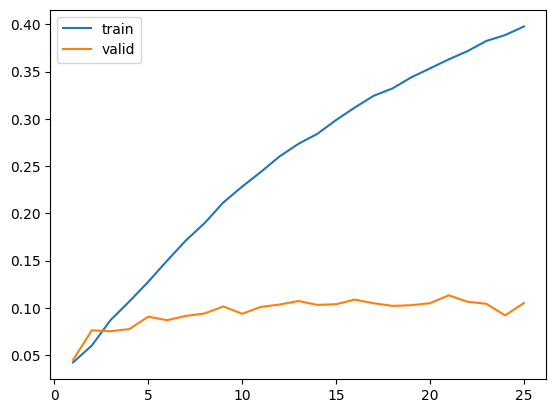

In [46]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [39]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.15))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))# La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2, 5)              16950     
                                                                 
 bidirectional_2 (Bidirectio  (None, 2, 64)            9728      
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 2, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 2, 128)            98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                      

In [ ]:
hist = model.fit(x_data, y_data, epochs=70, validation_split=0.2)

Epoch 1/70
1432/1432 [==============================] - 28s 15ms/step - loss: 6.1485 - accuracy: 0.0414 - val_loss: 6.4727 - val_accuracy: 0.0275
Epoch 2/70
1432/1432 [==============================] - 18s 13ms/step - loss: 5.8368 - accuracy: 0.0457 - val_loss: 6.4456 - val_accuracy: 0.0453
Epoch 3/70
1432/1432 [==============================] - 16s 12ms/step - loss: 5.5771 - accuracy: 0.0543 - val_loss: 6.3992 - val_accuracy: 0.0417
Epoch 4/70
1432/1432 [==============================] - 17s 12ms/step - loss: 5.3961 - accuracy: 0.0617 - val_loss: 6.5015 - val_accuracy: 0.0551
Epoch 5/70
1432/1432 [==============================] - 17s 12ms/step - loss: 5.2484 - accuracy: 0.0701 - val_loss: 6.6465 - val_accuracy: 0.0668
Epoch 6/70
1432/1432 [==============================] - 17s 12ms/step - loss: 5.1136 - accuracy: 0.0794 - val_loss: 6.7419 - val_accuracy: 0.0748
Epoch 7/70
1432/1432 [==============================] - 18s 12ms/step - loss: 4.9773 - accuracy: 0.0911 - val_loss: 6.8402 -

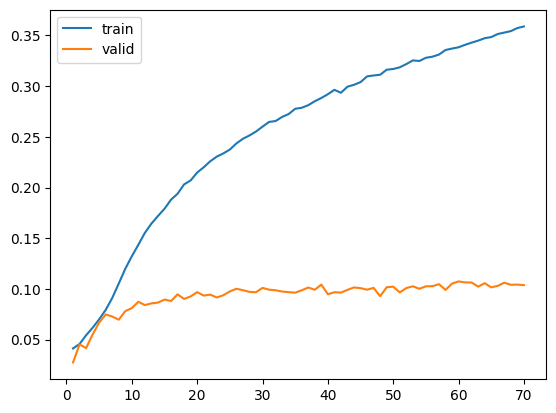

In [ ]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

Aumentando al doble la cantidad de neuronas de la capa LSTM, el accuracy no parece variar

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [45]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [47]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=2, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 21ms/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [47]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [49]:
input_text='where are'

generate_seq(model, tok, input_text, max_length=2, n_words=2)

1/1 [==============================] - 0s 20ms/step


'where are i was'

In [50]:
input_text='where are'

generate_seq(model, tok, input_text, max_length=2, n_words=5)

1/1 [==============================] - 0s 25ms/step


'where are i was door know '

In [51]:
input_text='never mind I'

generate_seq(model, tok, input_text, max_length=2, n_words=5)

1/1 [==============================] - 0s 25ms/step


'never mind I get me and  '

In [53]:
input_text='close your'

generate_seq(model, tok, input_text, max_length=2, n_words=7)

1/1 [==============================] - 0s 20ms/step


'close your feel      '

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

Conclusiones: Tras haber probado distintas redes, combinando variantes y además con distintos largos de secuencias, no pude obtener una accuracy mayor a 0.1. El desempeño fue muy malo y realizando cambios no lo pude mejorar. Se evidenció al utilizar gradio y el generador de secuencias.